In [1]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
import sklearn as sk
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
% pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [2]:
# Download data
url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
r = requests.get(url, allow_redirects=True)
open('data.rar', 'wb').write(r.content)
pyunpack.Archive('data.rar').extractall('')

base_dir = r"./Amazon Forest Dataset/"

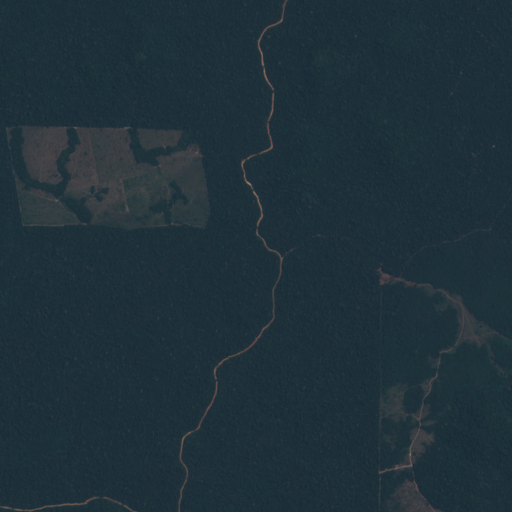

In [3]:
# Example image from training data
PIL.Image.open(r"{}Training/images/Amazon_1110.tiff_25.tiff".format(base_dir))

In [4]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images
test_images_list = os.listdir(r"{}Test/".format(base_dir))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/{}".format(base_dir,n))
  test_images.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [5]:
# Pre-process data
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(1,512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(1,512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

In [6]:
# Normalise images (if not dividing by 255, this is another method)
'''
normalised_1 = Normalizer().fit(training_images[0][0][:,:,0])
normalised_2 = Normalizer().fit(training_images[0][0][:,:,1])
normalised_3 = Normalizer().fit(training_images[0][0][:,:,2])
normalised_4 = Normalizer().fit(validation_images[0][0][:,:,0])
normalised_5 = Normalizer().fit(validation_images[0][0][:,:,1])
normalised_6 = Normalizer().fit(validation_images[0][0][:,:,2])

training_images[0][0][:,:,0] = normalised_1.transform(training_images[0][0][:,:,0])
training_images[0][0][:,:,1] = normalised_2.transform(training_images[0][0][:,:,1])
training_images[0][0][:,:,2] = normalised_3.transform(training_images[0][0][:,:,2])

validation_images[0][0][:,:,0] = normalised_4.transform(validation_images[0][0][:,:,0])
validation_images[0][0][:,:,1] = normalised_5.transform(validation_images[0][0][:,:,1])
validation_images[0][0][:,:,2] = normalised_6.transform(validation_images[0][0][:,:,2])
'''

'\nnormalised_1 = Normalizer().fit(training_images[0][0][:,:,0])\nnormalised_2 = Normalizer().fit(training_images[0][0][:,:,1])\nnormalised_3 = Normalizer().fit(training_images[0][0][:,:,2])\nnormalised_4 = Normalizer().fit(validation_images[0][0][:,:,0])\nnormalised_5 = Normalizer().fit(validation_images[0][0][:,:,1])\nnormalised_6 = Normalizer().fit(validation_images[0][0][:,:,2])\n\ntraining_images[0][0][:,:,0] = normalised_1.transform(training_images[0][0][:,:,0])\ntraining_images[0][0][:,:,1] = normalised_2.transform(training_images[0][0][:,:,1])\ntraining_images[0][0][:,:,2] = normalised_3.transform(training_images[0][0][:,:,2])\n\nvalidation_images[0][0][:,:,0] = normalised_4.transform(validation_images[0][0][:,:,0])\nvalidation_images[0][0][:,:,1] = normalised_5.transform(validation_images[0][0][:,:,1])\nvalidation_images[0][0][:,:,2] = normalised_6.transform(validation_images[0][0][:,:,2])\n'

In [7]:
# Create TensorFlow datasets for training and validation sets
train_df = tf.data.Dataset.from_tensor_slices((training_images, training_masks))
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

In [8]:
def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(drop_rate)(pool2)

    #pool2 = BatchNormalization()(drop2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(drop_rate)(pool3)

    #pool3 = BatchNormalization()(drop3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(drop_rate)(pool4) # Adds dropout (for testing)

    #pool4 = BatchNormalization()(drop4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    ## Expansion phase
    up6 = (UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([drop3,up6])#
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Dropout(drop_rate)(conv6)

    up7 = (UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])#
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Dropout(drop_rate)(conv7)

    up8 = (UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])#
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Dropout(drop_rate)(conv8)

    up9 = (UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])#
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [9]:
# Instantiate UNet and train
model = UNet()
save_model = ModelCheckpoint('unet-best.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(train_df.repeat(100), validation_data=validation_df, epochs=30, steps_per_epoch=100, shuffle=True, callbacks=[save_model])#, validation_data=validation_df)

Epoch 1/30
100/100 [==============================] - 50s 255ms/step - loss: 0.5400 - accuracy: 0.7059 - mse: 0.1841 - val_loss: 0.3027 - val_accuracy: 0.8775 - val_mse: 0.0923

Epoch 00001: loss improved from inf to 0.41028, saving model to unet-best.hdf5
Epoch 2/30
100/100 [==============================] - 25s 250ms/step - loss: 0.2398 - accuracy: 0.9145 - mse: 0.0661 - val_loss: 0.2624 - val_accuracy: 0.8912 - val_mse: 0.0805

Epoch 00002: loss improved from 0.41028 to 0.22711, saving model to unet-best.hdf5
Epoch 3/30
100/100 [==============================] - 25s 254ms/step - loss: 0.1903 - accuracy: 0.9345 - mse: 0.0510 - val_loss: 0.2639 - val_accuracy: 0.8923 - val_mse: 0.0805

Epoch 00003: loss improved from 0.22711 to 0.18933, saving model to unet-best.hdf5
Epoch 4/30
100/100 [==============================] - 26s 257ms/step - loss: 0.1853 - accuracy: 0.9335 - mse: 0.0506 - val_loss: 0.2181 - val_accuracy: 0.9152 - val_mse: 0.0641

Epoch 00004: loss improved from 0.18933 to 

In [10]:
# Save model
model.save('unet.h5')

In [11]:
# Save weights
model.save_weights('weights.h5')

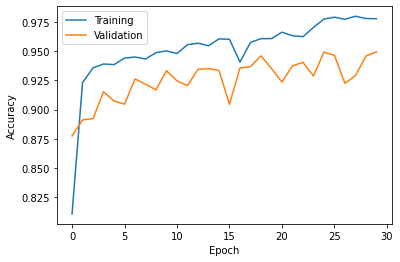

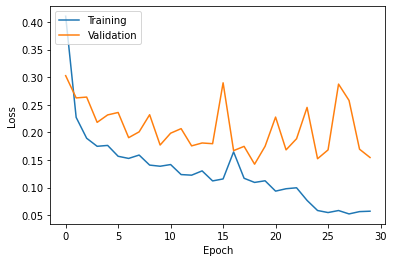

In [12]:
# Plot accuracy and loss 

## Accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [13]:
# Show model structure
##model.summary()

In [14]:
# Show picture of model structure
##keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Functions

In [15]:
def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 

In [16]:
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [17]:
def score_eval(model, image, mask): # Need to check this is working properly
  reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
  error = np.round(reconstruction).flatten() - (mask).flatten()

  return np.dot(error, error)/len(error)

# Plot validation image, with mask, and reconstructions

<Figure size 432x288 with 0 Axes>

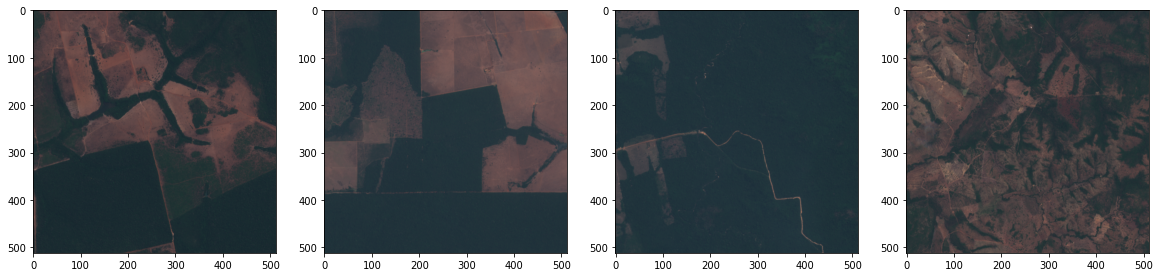

In [18]:
# Plot a selection of validation set images
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(validation_images[1].reshape(512,512,3))
ax[1].imshow(validation_images[2].reshape(512,512,3))
ax[2].imshow(validation_images[3].reshape(512,512,3))
ax[3].imshow(validation_images[4].reshape(512,512,3))

<Figure size 432x288 with 0 Axes>

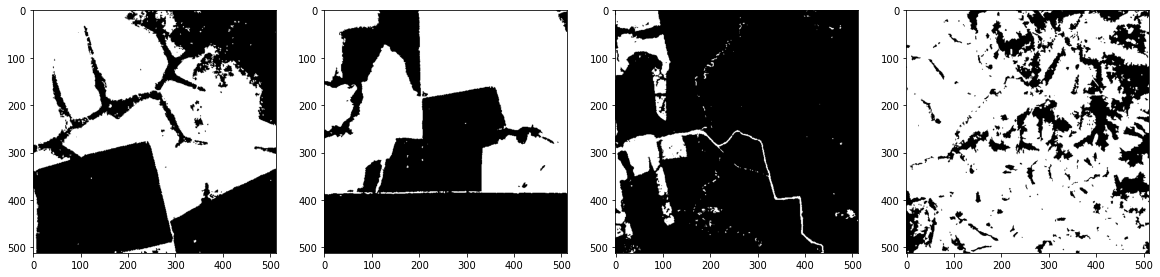

In [19]:
# Plot corresponding validation set masks
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(validation_masks[1].reshape(512,512), cmap='gray')
ax[1].imshow(validation_masks[2].reshape(512,512), cmap='gray')
ax[2].imshow(validation_masks[3].reshape(512,512), cmap='gray')
ax[3].imshow(validation_masks[4].reshape(512,512), cmap='gray')

<Figure size 432x288 with 0 Axes>

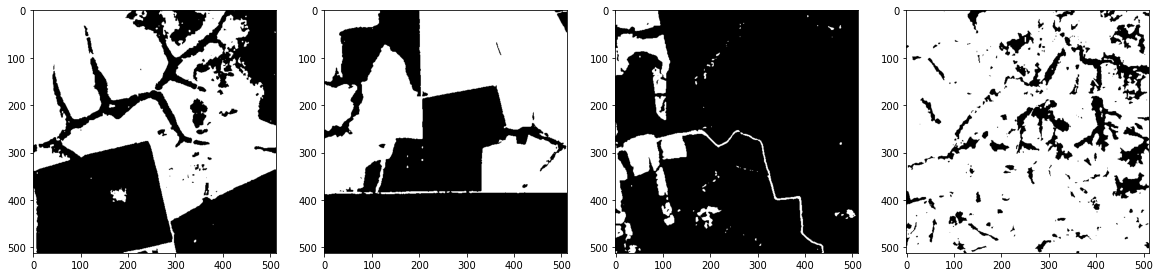

In [20]:
# Plot reconstructions/predictions of masks for corresponding validation set images (rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model, validation_images[1], rounded=True), cmap='gray')
ax[1].imshow(reconstruct_array(model, validation_images[2], rounded=True), cmap='gray')
ax[2].imshow(reconstruct_array(model, validation_images[3], rounded=True), cmap='gray')
ax[3].imshow(reconstruct_array(model, validation_images[4], rounded=True), cmap='gray')

<Figure size 432x288 with 0 Axes>

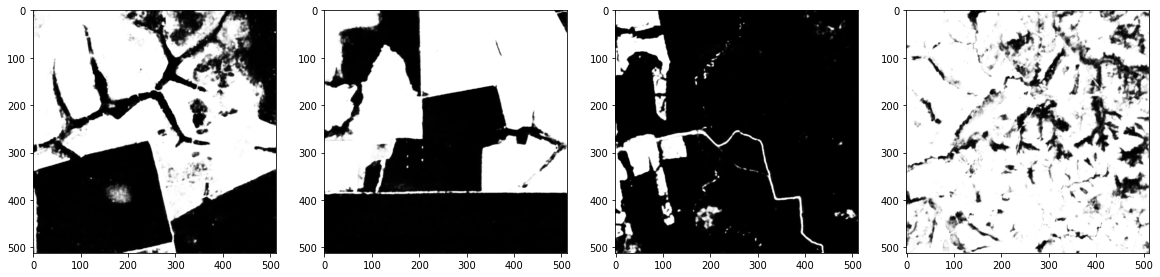

In [21]:
# Plot reconstructions/predictions of masks for corresponding validation set images (not rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model, validation_images[1], rounded=False), cmap='gray')
ax[1].imshow(reconstruct_array(model, validation_images[2], rounded=False), cmap='gray')
ax[2].imshow(reconstruct_array(model, validation_images[3], rounded=False), cmap='gray')
ax[3].imshow(reconstruct_array(model, validation_images[4], rounded=False), cmap='gray')

# Plot test images and reconstructions

<Figure size 432x288 with 0 Axes>

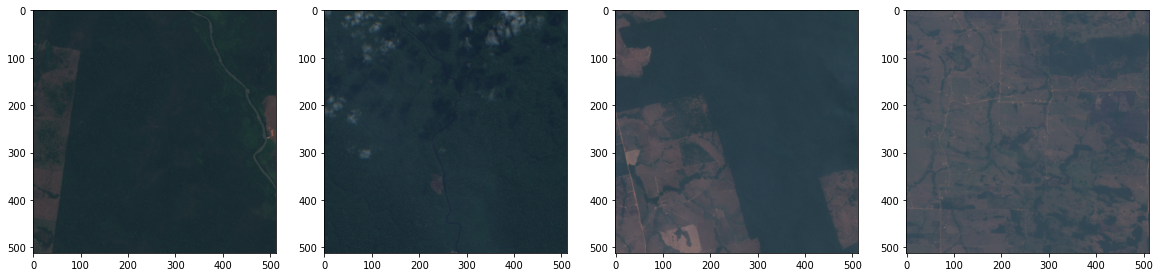

In [22]:
# Plot a selection of test set images
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(test_images[1].reshape(512,512,3))
ax[1].imshow(test_images[2].reshape(512,512,3))
ax[2].imshow(test_images[3].reshape(512,512,3))
ax[3].imshow(test_images[4].reshape(512,512,3))

<Figure size 432x288 with 0 Axes>

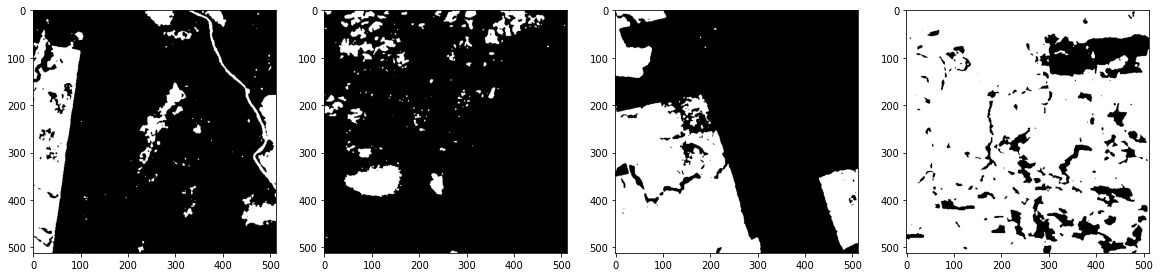

In [23]:
# Plot corresponding reconstructions/predictions (rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model, test_images[1], rounded=True), cmap='gray')
ax[1].imshow(reconstruct_array(model, test_images[2], rounded=True), cmap='gray')
ax[2].imshow(reconstruct_array(model, test_images[3], rounded=True), cmap='gray')
ax[3].imshow(reconstruct_array(model, test_images[4], rounded=True), cmap='gray')

<Figure size 432x288 with 0 Axes>

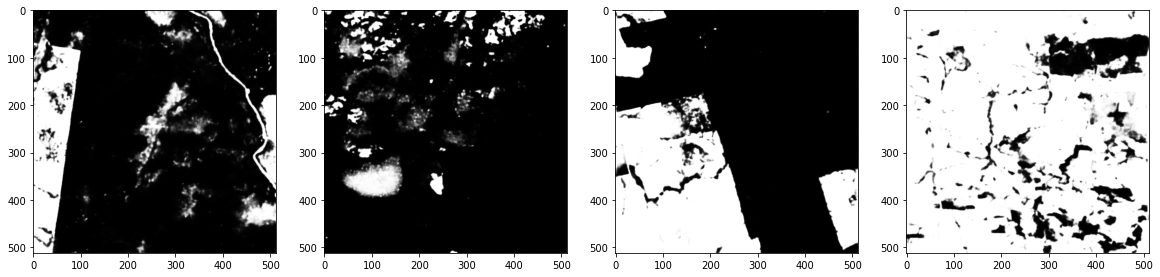

In [24]:
# Plot corresponding reconstructions/predictions (not rounded)
plt.figure()
fig, ax = plt.subplots(1,4, figsize=(20,10)) 
ax[0].imshow(reconstruct_array(model, test_images[1]), cmap='gray')
ax[1].imshow(reconstruct_array(model, test_images[2]), cmap='gray')
ax[2].imshow(reconstruct_array(model, test_images[3]), cmap='gray')
ax[3].imshow(reconstruct_array(model, test_images[4]), cmap='gray')